# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [2]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

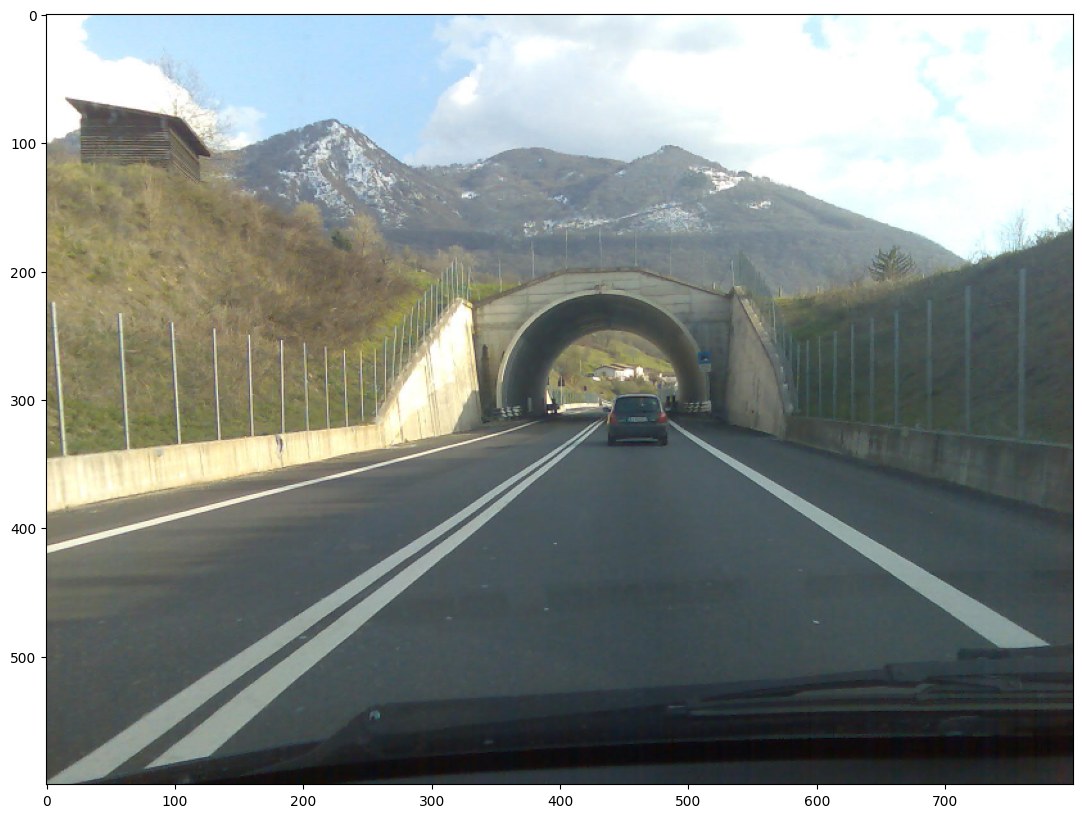

In [3]:
img = cv2.imread('data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [4]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [5]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150

edges =cv2.Canny(gray, threshold1=100, threshold2=150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

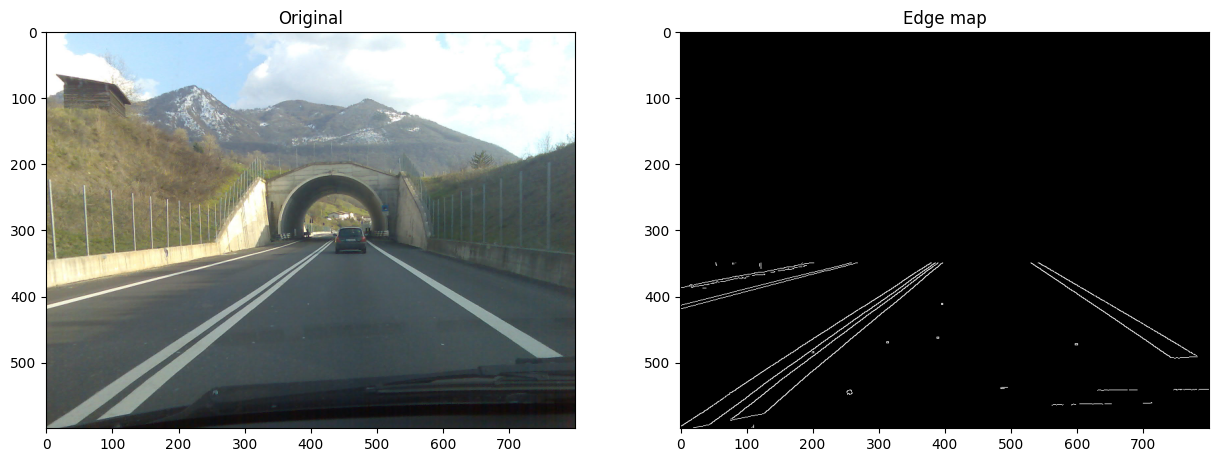

In [6]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [7]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!   use 210
lines = cv2.HoughLines(edges, rho=1, theta=2*np.pi/180, threshold=210)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

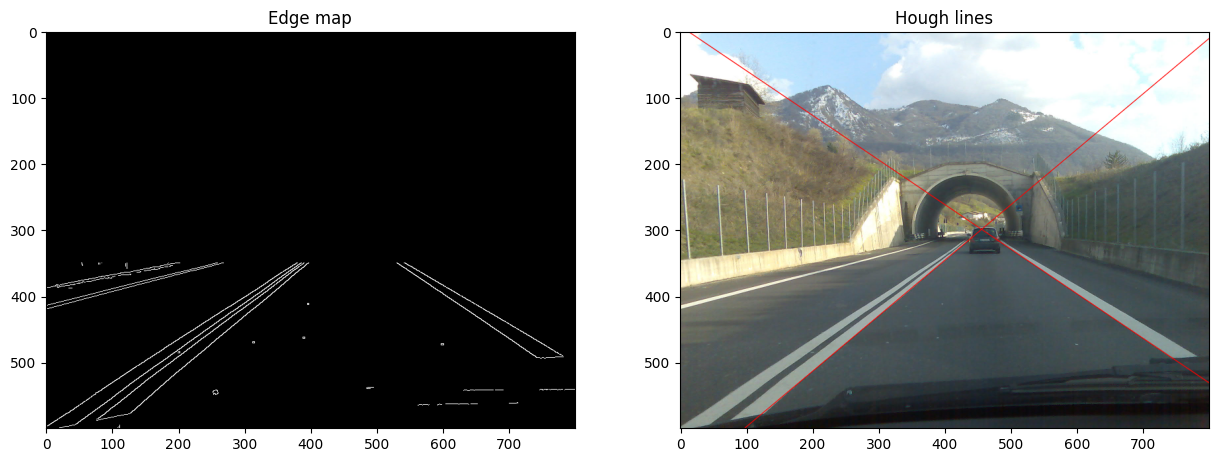

In [8]:
# Plot the resulting Hough lines
result = np.copy(img)

  
for line in lines:
    rho = line[0]
    theta = line[1]
   
   
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [10]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!   use 190
lines = cv2.HoughLines(edges, rho=3, theta=2*np.pi/180, threshold=190)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

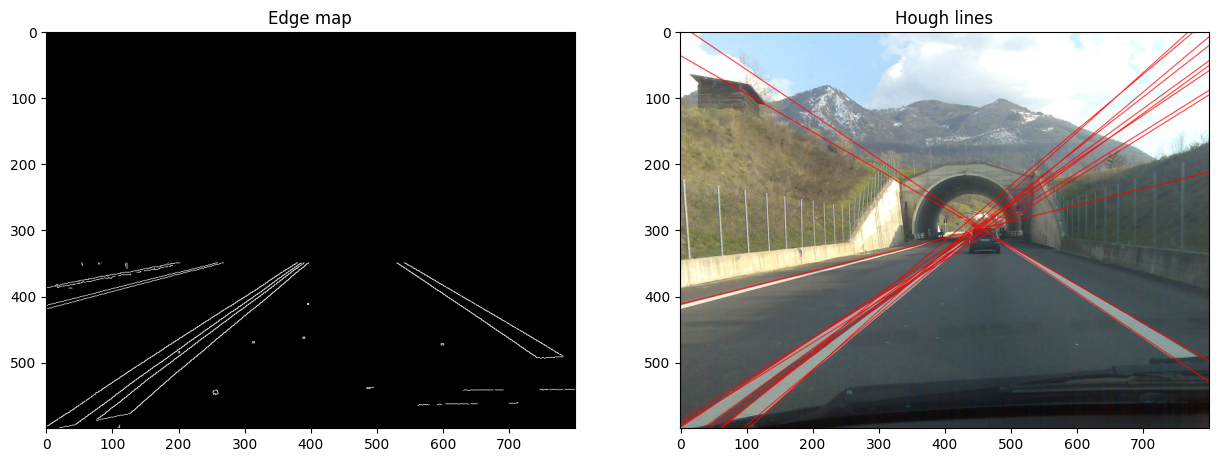

In [11]:
# Plot the resulting Hough lines
result = np.copy(img)

  
for line in lines:
    rho = line[0]
    theta = line[1]
   
   
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [13]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 

start=np.pi/2-2*np.pi/18
end=np.pi/2+2*np.pi/18

filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1]
    # Keep line if theta is not horizontal
    if theta <start or theta>end:
        filtered_lines.append(line)

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

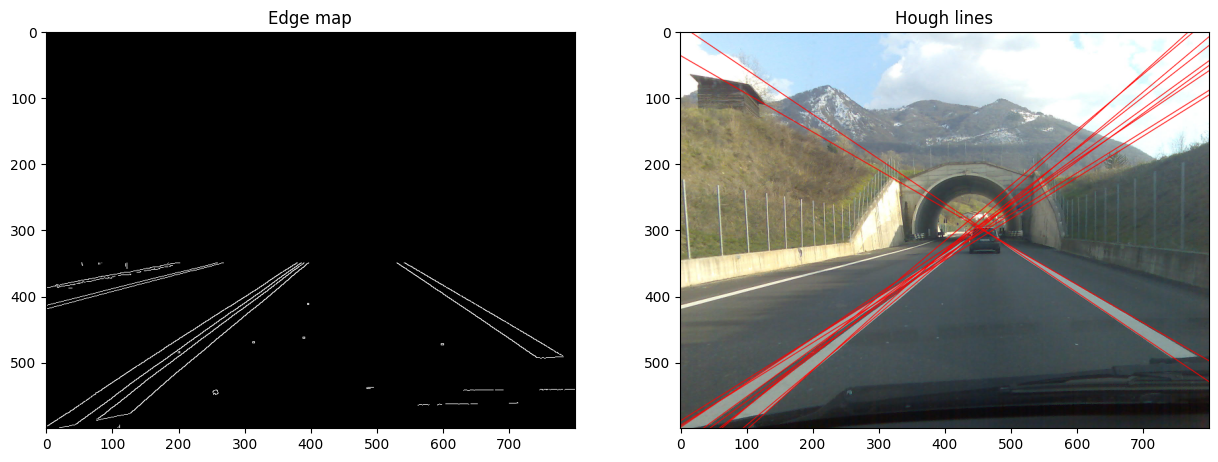

In [42]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
   
   
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [54]:
pip install -U scikit-learn scipy matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/11.0 MB 1.3 MB/s eta 0:00:09
     --------------------------------------- 0.1/11.0 MB 650.2 kB/s eta 0:00:17
     --------------------------------------- 0.1/11.0 MB 837.8 kB/s eta 0:00:14
     --------------------------------------- 0.1/11.0 MB 837.8 kB/s eta 0:00:14
     --------------------------------------- 0.1/11.0 MB 714.4 kB/s eta 0:00:16
      --------------------------------------- 0.3/11.0 MB 1.1 MB/s eta 0:00:10
     - -------------------------------------- 0.3/11.0 MB 1.2 MB/s eta 0:00:10
     - -------------------------------------- 0.3/11.0 MB 1.1 MB/s eta 0:00:10
     - -------------------------------------- 0.5/11.0 MB 1.3 MB/s eta 0:00:08
     - -------------------------------------- 0.5/11.0 MB 1.3 MB/s eta 0:00:08
     -- ------------------------------------- 0.6/11.0 M


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:

# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(filtered_lines)
kmeans.cluster_centers_

array([[ 31.5       ,   2.09439516],
       [507.75      ,   0.95120442],
       [ -7.5       ,   2.16420817],
       [498.5       ,   0.95411332],
       [517.5       ,   0.85521135]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

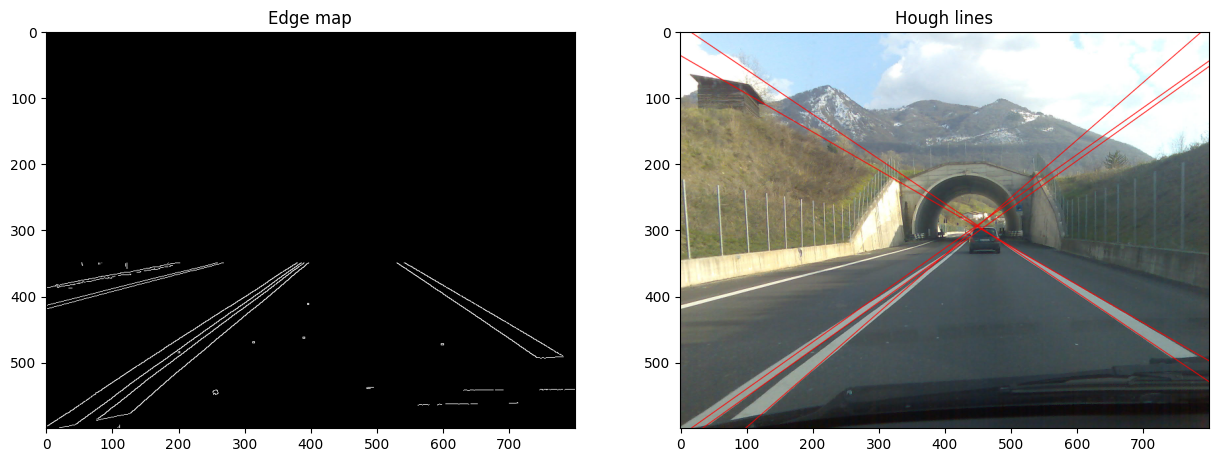

In [51]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
   
   
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)


plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result?
* Do you think the Hough transform resolution is important for obtaining a good result? Why?
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?

* Do you see anything strange in the final result?
Unfortunaly no, becouse I didn't get any noisy lines ufter  Hough transform
First I used lines = cv2.HoughLines(edges, rho=1, theta=2*np.pi/180, threshold=210)  and get only 2 nessesary lines